In [ ]:
pip install transformers

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 38.2 MB/s 
     |████████████████████████████████| 3.3 MB 33.4 MB/s 
     |████████████████████████████████| 52 kB 892 kB/s 
     |████████████████████████████████| 636 kB 35.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install pymediawiki

In [ ]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, linear_kernel
import pandas as pd
import numpy as np
from numpy import genfromtxt
import torch
import math

In [ ]:
url = 'https://raw.githubusercontent.com/casszhao/contextualizing-hate-speech-models-with-explanations/master/results/4data_BERT_IT_allresults.csv'
IT_allresults = pd.read_csv(url)
IT_allresults

,Unnamed: 0,label,prediction,text,Subjectivity Score,Data,Result
0,0,0,0,"hello , angel , just wanted to say hi i live i...",0.250000,WS,True Negative
1,1,0,0,i ' ve seen university of cape town ' s websit...,0.250000,WS,True Negative
2,2,0,0,nothing was in je ##por ##dy this year and fur...,0.433333,WS,True Negative
3,3,1,0,why white people used to say that sex was a si...,0.125000,WS,False Negative
4,4,0,0,- sending their kids to jewish summer camps .,0.000000,WS,True Negative
...,...,...,...,...,...,...,...
1546,771,0,0,which one religion is true and complete which ...,0.482143,Wiki,True Negative
1547,772,0,0,""" this source provides some further en ##light...",0.366270,Wiki,True Negative
1548,773,0,0,""" bt ##w mar ##gh ##eri ##ta ' s other boyfrie...",0.383333,Wiki,True Negative
1549,774,0,0,that ' s not universally correct . many non - ...,0.305556,Wiki,True Negative


In [ ]:
comment_1 = IT_allresults['text'][1]
comment_2 = IT_allresults['text'][2]

## define model

In [ ]:
model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

## get embeddings of the term which will be treated as **Absolute Objective**

Here we use example of "Liberalism" (for "liberal") and "Muslims"

"muslim|jew|jews|white|islam|blacks|muslims|women|whites|gay|black|democat|islamic|allah|jewish|lesbian|transgender|race|brown|woman|mexican|religion|homosexual|homosexuality|africans"


In [ ]:
def get_request_array(request, MAX_TOKEN=200):
  request_token = tokenizer.encode_plus(request, max_length=MAX_TOKEN, # length from 128 to 20
                                      truncation=True, padding='max_length',
                                      return_tensors='pt')

  request_id = request_token['input_ids'][0]
  request_attention_mask = request_token['attention_mask'][0]

  request_outputs = model(**request_token)
  request_embeddings = request_outputs.last_hidden_state
  request_mask = request_attention_mask.unsqueeze(-1).expand(request_embeddings.size()).float()
  request_masked_embeddings = request_embeddings * request_mask
  request_summed = torch.sum(request_masked_embeddings, 1)
  request_summed_mask = torch.clamp(request_mask.sum(1), min=1e-9)
  request_mean_pooled = request_summed / request_summed_mask
  return request_mean_pooled.detach().numpy()

In [ ]:
from mediawiki import MediaWiki
wikipedia = MediaWiki()

def get_absolute_emb(terms):
  page = wikipedia.page(terms)
  summary = page.summary
  return get_request_array(request=terms, MAX_TOKEN=500)

In [ ]:
identity_list = ['muslim','jew','jews','white','islam','blacks','muslims','women','whites','gay','black','democat','islamic','allah','jewish',
                 'lesbian','transgender','race','brown','woman','mexican','religion','homosexual','homosexuality','africans']

In [ ]:
array = get_absolute_emb('Race (human categorization)')

In [ ]:
array_list = []
for identity in identity_list:
  if identity == 'race':
    array = get_absolute_emb('Race (human categorization)')
    array_list.append(array)
  elif identity == 'mexican':
    array = get_absolute_emb('Mexicans')
    array_list.append(array)
  else:
    array = get_absolute_emb(identity)
    array_list.append(array)

# identity_embed_array = pd.DataFrame(list(zip(identity_list, array_list)), columns = ['identity', 'embedding_array'])
# identity_embed_array.to_csv('identity_embed_array.csv')

In [ ]:
identity_dictionary = {identity_list[i]: array_list[i] for i in range(len(identity_list))}

In [ ]:
len(identity_dictionary['africans'][0])

768

## get embeddings for comments that we want to investigate

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from scipy.spatial import distance

In [ ]:
def get_cosine_similarity(identity_term_contained, text_embeddings_arrary):
  ab_objective_embedding_array = np.array([identity_dictionary[identity_term_contained]])
  return cosine_similarity(ab_objective_embedding_array, text_embeddings_arrary)

In [ ]:
identity_terms_contained_list = []
for text in IT_allresults['text']:
  # text_array = get_request_array(text)
  tokens = word_tokenize(text)
  identity_terms_contained = list(set.intersection(set(identity_list), set(tokens)))
  identity_terms_contained_list.append(identity_terms_contained)

IT_allresults['id_terms_contained'] = identity_terms_contained_list
print(len(IT_allresults))
IT_allresults = IT_allresults[IT_allresults['id_terms_contained'].map(len) != 0]
print(len(IT_allresults))

1551
1461


In [ ]:
cosine_list = []
for i, text in enumerate(IT_allresults['text']):

  text_array = get_request_array(text)
  tokens = word_tokenize(text)
  identity_terms_contained = list(set.intersection(set(identity_list), set(tokens)))

  if len(identity_terms_contained) <= 1:
    ab_objective_embedding_array = identity_dictionary[identity_terms_contained[0]]
    final_cosine = abs(distance.cosine(ab_objective_embedding_array[0], text_array))
  else:
    for i, identity_term_contained in enumerate(identity_terms_contained):
      ab_objective_embedding_array = identity_dictionary[identity_term_contained]
      one_cosine = abs(distance.cosine(ab_objective_embedding_array[0], text_array[0]))
      if i == 0:
        final_cosine = one_cosine
      else:
        final_cosine = final_cosine + one_cosine

    # print('final_cosine', final_cosine)
    final_cosine = final_cosine/len(identity_terms_contained)

  cosine_list.append(final_cosine)

In [ ]:
cosine_list = []
for text in IT_allresults['text']:
  text_array = get_request_array(text)
  tokens = word_tokenize(text)
  identity_terms_contained = list(set.intersection(set(identity_list), set(tokens)))

  if len(identity_terms_contained) <= 1:
    ab_objective_embedding_array = identity_dictionary[identity_terms_contained[0]]
    final_cosine = abs(cosine_similarity(ab_objective_embedding_array, text_array))
  else:
    for i, identity_term_contained in enumerate(identity_terms_contained):
      ab_objective_embedding_array = identity_dictionary[identity_term_contained]
      one_cosine = abs(cosine_similarity(ab_objective_embedding_array, text_array))
      if i == 0:
        final_cosine = one_cosine
      else:
        final_cosine = final_cosine + one_cosine


    final_cosine = sum(final_cosine)/len(identity_terms_contained)
  cosine_list.append(final_cosine)

In [ ]:
IT_allresults['cosine'] =  cosine_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
IT_allresults

,Unnamed: 0,label,prediction,text,Subjectivity Score,Data,Result,id_terms_contained,cosine
0,0,0,0,"hello , angel , just wanted to say hi i live i...",0.250000,WS,True Negative,[white],0.809976
1,1,0,0,i ' ve seen university of cape town ' s websit...,0.250000,WS,True Negative,[white],1.023113
2,2,0,0,nothing was in je ##por ##dy this year and fur...,0.433333,WS,True Negative,[black],0.965389
3,3,1,0,why white people used to say that sex was a si...,0.125000,WS,False Negative,"[race, white]",0.794740
4,4,0,0,- sending their kids to jewish summer camps .,0.000000,WS,True Negative,[jewish],0.629941
...,...,...,...,...,...,...,...,...,...
1546,771,0,0,which one religion is true and complete which ...,0.482143,Wiki,True Negative,[religion],0.620525
1547,772,0,0,""" this source provides some further en ##light...",0.366270,Wiki,True Negative,[transgender],0.650411
1548,773,0,0,""" bt ##w mar ##gh ##eri ##ta ' s other boyfrie...",0.383333,Wiki,True Negative,[woman],0.916197
1549,774,0,0,that ' s not universally correct . many non - ...,0.305556,Wiki,True Negative,"[muslims, jews]",0.708551


In [ ]:
IT_allresults['cosine'] = IT_allresults['cosine'].str[0]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

## Overall incorrect predictions 

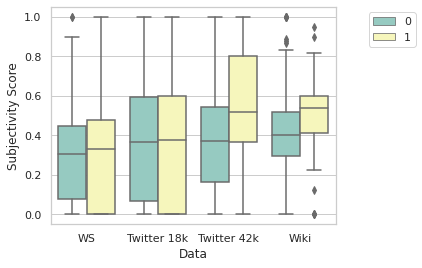

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Data", y="Subjectivity Score", hue="label",
                 data=IT_allresults, palette="Set3")
# ax.despine(left=True)
# plt.legend(loc='upper left')
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# ax.set_xlabel('xlabel')
# ax.set_ylabel('ylabel')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)#bbox_to_anchor=(1.4, 1),左右 越大越右 上下 越大约上
plt.show()

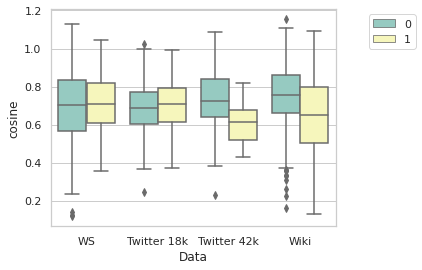

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Data", y="cosine", hue="label",
                 data=IT_allresults, palette="Set3")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)#bbox_to_anchor=(1.4, 1),左右 越大越右 上下 越大约上
plt.show()

## Only False positive and True positive

In [ ]:
FP_TP = IT_allresults[(IT_allresults['Result'] == 'False Positive') | (IT_allresults['Result'] == 'True Positive')]
FP_TP

,Unnamed: 0,label,prediction,text,Subjectivity Score,Data,Result,id_terms_contained,cosine
7,7,0,1,too many whites think they deserve what negro ...,0.500000,WS,False Positive,[whites],0.298650
10,10,1,1,i am not ukrainian but the ukraine nationalist...,0.229464,WS,True Positive,"[whites, race, white]",NaN
12,12,1,1,one reason we moved out of our ( at one time 9...,0.333333,WS,True Positive,[white],0.005505
15,15,0,1,elimination of all things white .,0.000000,WS,False Positive,[white],0.524619
16,16,0,1,my favorite part . sheds some light on how the...,0.555154,WS,False Positive,[jew],0.129493
...,...,...,...,...,...,...,...,...,...
1530,755,1,1,"he ' s gay . trust me . really , really gay . ...",0.583333,Wiki,True Positive,[gay],0.840352
1534,759,1,1,what the heck is a woman artist ? ? ? is this ...,0.223333,Wiki,True Positive,[woman],0.428059
1540,765,0,1,"no , i ' m not a member of the los angeles cou...",0.473810,Wiki,False Positive,[woman],-0.108728
1545,770,1,1,and won ' t be back like that gay fucking bast...,0.461111,Wiki,True Positive,[gay],0.473808


In [ ]:
FP_TP['cosine'] = FP_TP['cosine'].abs()
FP_TP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,label,prediction,text,Subjectivity Score,Data,Result,id_terms_contained,cosine
7,7,0,1,too many whites think they deserve what negro ...,0.500000,WS,False Positive,[whites],0.298650
10,10,1,1,i am not ukrainian but the ukraine nationalist...,0.229464,WS,True Positive,"[whites, race, white]",NaN
12,12,1,1,one reason we moved out of our ( at one time 9...,0.333333,WS,True Positive,[white],0.005505
15,15,0,1,elimination of all things white .,0.000000,WS,False Positive,[white],0.524619
16,16,0,1,my favorite part . sheds some light on how the...,0.555154,WS,False Positive,[jew],0.129493
...,...,...,...,...,...,...,...,...,...
1530,755,1,1,"he ' s gay . trust me . really , really gay . ...",0.583333,Wiki,True Positive,[gay],0.840352
1534,759,1,1,what the heck is a woman artist ? ? ? is this ...,0.223333,Wiki,True Positive,[woman],0.428059
1540,765,0,1,"no , i ' m not a member of the los angeles cou...",0.473810,Wiki,False Positive,[woman],0.108728
1545,770,1,1,and won ' t be back like that gay fucking bast...,0.461111,Wiki,True Positive,[gay],0.473808


In [ ]:
import seaborn as sns

In [ ]:
url = 'https://raw.githubusercontent.com/casszhao/contextualizing-hate-speech-models-with-explanations/master/results/IT_cosine.csv'
FP_TP = pd.read_csv(url)
FP_TP

,Unnamed: 0,Unnamed: 0.1,label,prediction,text,Subjectivity Score,Data,Result,id_terms_contained,cosine
0,0,0,0,0,"hello , angel , just wanted to say hi i live i...",0.250000,WS,True Negative,['white'],0.190024
1,1,1,0,0,i ' ve seen university of cape town ' s websit...,0.250000,WS,True Negative,['white'],0.023113
2,2,2,0,0,nothing was in je ##por ##dy this year and fur...,0.433333,WS,True Negative,['black'],0.034611
3,3,3,1,0,why white people used to say that sex was a si...,0.125000,WS,False Negative,"['race', 'white']",0.205260
4,4,4,0,0,- sending their kids to jewish summer camps .,0.000000,WS,True Negative,['jewish'],0.370059
...,...,...,...,...,...,...,...,...,...,...
1456,1546,771,0,0,which one religion is true and complete which ...,0.482143,Wiki,True Negative,['religion'],0.379475
1457,1547,772,0,0,""" this source provides some further en ##light...",0.366270,Wiki,True Negative,['transgender'],0.349589
1458,1548,773,0,0,""" bt ##w mar ##gh ##eri ##ta ' s other boyfrie...",0.383333,Wiki,True Negative,['woman'],0.083803
1459,1549,774,0,0,that ' s not universally correct . many non - ...,0.305556,Wiki,True Negative,"['muslims', 'jews']",0.291449


NameError: ignored

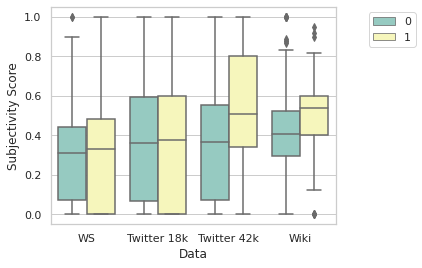

In [ ]:
url = 'https://raw.githubusercontent.com/casszhao/contextualizing-hate-speech-models-with-explanations/master/results/4data_BERT_IT_allresults.csv'
IT_allresults = pd.read_csv(url)
IT_allresults

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Data", y="Subjectivity Score", hue="label",
                 data=IT_allresults, palette="Set3")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)   #bbox_to_anchor=(1.4, 1),左右 越大越右 上下 越大约上
plt.show()

NameError: ignored

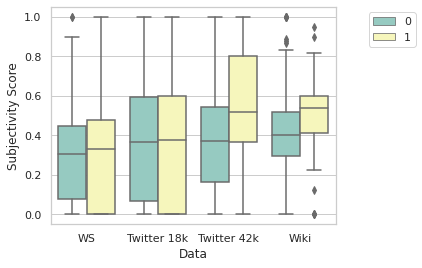

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Data", y="Subjectivity Score", hue="label",
                 data=FP_TP, palette="Set3")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)   #bbox_to_anchor=(1.4, 1),左右 越大越右 上下 越大约上
plt.show()

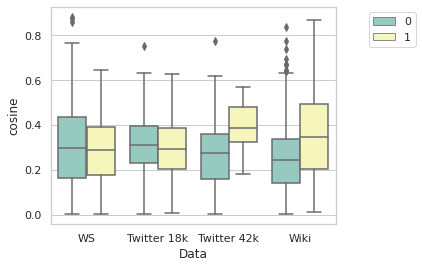

In [ ]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Data", y="cosine", hue="label",
                 data=FP_TP, palette="Set3")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)   #bbox_to_anchor=(1.4, 1),左右 越大越右 上下 越大约上
# plt.show()


## cosine similarity

input a topic embedding array and get its cosine similar topics

In [ ]:
cosine_1 = cosine_similarity(topic_array, comment_1_array)
cosine_2 = cosine_similarity(topic_array, comment_2_array)
print('cosine similarity for comment 1: ', cosine_1)
print('cosine similarity for comment 2: ', cosine_2)

we can see comment 1 is "closer" to the "absolute obective" description of Muslim (which is the summary of muslim from wikipeida)

(The closer the cosine value to 1, the smaller the angle and the greater the match between vectors.) which means more objective (diffferent from TextBlob and Sentwordnet)

## euclidean distances

In [ ]:
distance_1 = euclidean_distances(topic_array, comment_1_array)
distance_2 = euclidean_distances(topic_array, comment_2_array)
print('distance between the wiki summary and comment 1: ', distance_1)
print('distance between the wiki summary and comment 2: ', distance_2)

we can see comment 1 is "closer" to the "absolute obective" description of Muslim (which is the summary of muslim from wikipeida)

(the distance can be roughly interpreated as the distance between two "point")